# Ejemplo Red CNN

In [1]:
import matplotlib.pyplot as plt
#matplotlib.use("Agg")

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import re
from datetime import datetime
import imutils

Using Theano backend.
/home/dramon/anaconda3/envs/dlearn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dramon/anaconda3/envs/dlearn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dramon/anaconda3/envs/dlearn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dramon/anaconda3/e

In [2]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [24]:
EPOCHS = 200
INIT_LR = 1e-3
# its important the batch size be smaller than the total samples
BS = 5  # 32
RESIZE_SHAPE = (56, 56)

In [4]:
print("[INFO] loading images...")
data = []
# List all the images in class folders
list_images = list(paths.list_images("./Trainset"))

[INFO] loading images...


In [5]:
random.seed(42)
random.shuffle(list_images)
# get the id class by the folder name
labels = list(map(lambda x: x.split("/")[2], list_images))
# Load all images

In [6]:
claseno = {'Luffy': 0, 'NoLuffy': 1}
codedlabels = list(map(lambda x: claseno[x], labels))

In [7]:
# Hace lo mismo que lo que hicimos con el diccionario
from sklearn.preprocessing import LabelEncoder
LabelEncoder().fit_transform(labels)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [8]:
for imagePath in list_images:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
    image = cv2.resize(image, RESIZE_SHAPE)
    image = img_to_array(image)
    data.append(image)
    # preprocess all the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


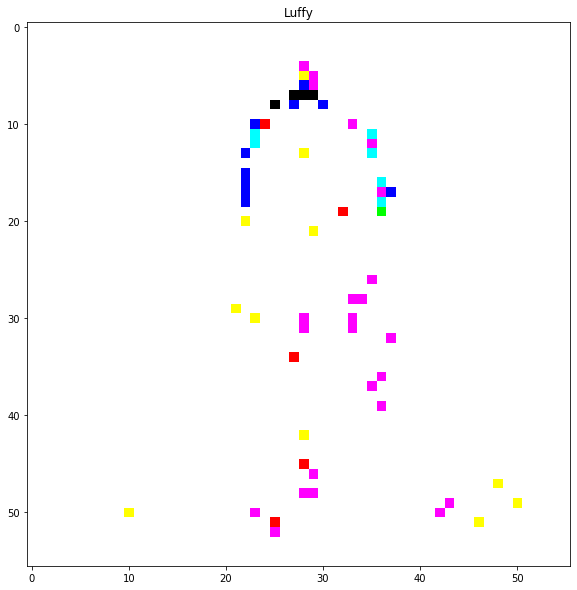

In [9]:
plt.figure(figsize=(10,10))
n = 8
plt.imshow(imutils.opencv2matplotlib(data[n]))
plt.title(labels[n])
plt.show()

In [10]:
# preprocess all the images
data = np.array(data, dtype="float") / 255.0
codedlabels = np.array(codedlabels)
(trainX, testX, trainY, testY) = train_test_split(data,\
    codedlabels, test_size=0.25, random_state=42)

In [11]:
# Class amount and layers
nclasses = len(np.unique(labels))
layer_depth = data.shape[-1]
# The categorical Y entries
trainY = to_categorical(trainY, num_classes=nclasses)
testY = to_categorical(testY, num_classes=nclasses)

In [12]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
        horizontal_flip=True, fill_mode="nearest")

In [13]:
print("[INFO] compiling model...")
w, h = RESIZE_SHAPE
model = LeNet.build(width=w, height=h, depth=layer_depth, classes=nclasses)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
# Running model training

[INFO] compiling model...


In [25]:
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)
# save the model to disk

[INFO] training network...
Epoch 1/200
2/2 [==============================] - 0s 85ms/step - loss: 0.2678 - accuracy: 0.9000 - val_loss: 2.0074 - val_accuracy: 0.5000
Epoch 2/200
2/2 [==============================] - 0s 95ms/step - loss: 0.2939 - accuracy: 0.8571 - val_loss: 1.8072 - val_accuracy: 0.5000
Epoch 3/200
2/2 [==============================] - 0s 60ms/step - loss: 0.3334 - accuracy: 0.8571 - val_loss: 1.5989 - val_accuracy: 0.5000
Epoch 4/200
2/2 [==============================] - 0s 108ms/step - loss: 0.5255 - accuracy: 0.8571 - val_loss: 1.5546 - val_accuracy: 0.5000
Epoch 5/200
2/2 [==============================] - 0s 103ms/step - loss: 0.1631 - accuracy: 0.9000 - val_loss: 1.5221 - val_accuracy: 0.5000
Epoch 6/200
2/2 [==============================] - 0s 63ms/step - loss: 0.3137 - accuracy: 0.8571 - val_loss: 1.4314 - val_accuracy: 0.5000
Epoch 7/200
2/2 [==============================] - 0s 116ms/step - loss: 0.3080 - accuracy: 1.0000 - val_loss: 1.5586 - val_accurac

Epoch 59/200
2/2 [==============================] - 0s 104ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 3.7624 - val_accuracy: 0.5000
Epoch 60/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 3.9610 - val_accuracy: 0.5000
Epoch 61/200
2/2 [==============================] - 0s 92ms/step - loss: 0.0379 - accuracy: 1.0000 - val_loss: 4.1990 - val_accuracy: 0.5000
Epoch 62/200
2/2 [==============================] - 0s 150ms/step - loss: 0.6323 - accuracy: 0.9000 - val_loss: 4.2606 - val_accuracy: 0.5000
Epoch 63/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 4.1783 - val_accuracy: 0.5000
Epoch 64/200
2/2 [==============================] - 0s 103ms/step - loss: 0.0933 - accuracy: 1.0000 - val_loss: 4.2912 - val_accuracy: 0.5000
Epoch 65/200
2/2 [==============================] - 0s 85ms/step - loss: 0.0619 - accuracy: 1.0000 - val_loss: 4.3942 - val_accuracy: 0.5000
Epoch 66/2

Epoch 117/200
2/2 [==============================] - 0s 62ms/step - loss: 0.1138 - accuracy: 1.0000 - val_loss: 5.0113 - val_accuracy: 0.2500
Epoch 118/200
2/2 [==============================] - 0s 95ms/step - loss: 0.5740 - accuracy: 0.8571 - val_loss: 4.7059 - val_accuracy: 0.2500
Epoch 119/200
2/2 [==============================] - 0s 91ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 5.3388 - val_accuracy: 0.2500
Epoch 120/200
2/2 [==============================] - 0s 78ms/step - loss: 0.8462 - accuracy: 0.8000 - val_loss: 3.7187 - val_accuracy: 0.5000
Epoch 121/200
2/2 [==============================] - 0s 87ms/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 2.4679 - val_accuracy: 0.5000
Epoch 122/200
2/2 [==============================] - 0s 99ms/step - loss: 0.0822 - accuracy: 1.0000 - val_loss: 1.9114 - val_accuracy: 0.5000
Epoch 123/200
2/2 [==============================] - 0s 67ms/step - loss: 0.2403 - accuracy: 0.8000 - val_loss: 1.9203 - val_accuracy: 0.5000
Epoch 

2/2 [==============================] - 0s 66ms/step - loss: 0.4969 - accuracy: 0.8571 - val_loss: 4.0993 - val_accuracy: 0.7500
Epoch 175/200
2/2 [==============================] - 0s 107ms/step - loss: 0.2802 - accuracy: 0.8571 - val_loss: 5.5757 - val_accuracy: 0.5000
Epoch 176/200
2/2 [==============================] - 0s 107ms/step - loss: 0.0455 - accuracy: 1.0000 - val_loss: 5.5267 - val_accuracy: 0.5000
Epoch 177/200
2/2 [==============================] - 0s 65ms/step - loss: 0.1887 - accuracy: 0.8571 - val_loss: 5.0793 - val_accuracy: 0.5000
Epoch 178/200
2/2 [==============================] - 0s 118ms/step - loss: 0.0608 - accuracy: 1.0000 - val_loss: 4.4739 - val_accuracy: 0.5000
Epoch 179/200
2/2 [==============================] - 0s 73ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 4.1142 - val_accuracy: 0.5000
Epoch 180/200
2/2 [==============================] - 0s 72ms/step - loss: 0.6781 - accuracy: 0.9000 - val_loss: 3.9290 - val_accuracy: 0.5000
Epoch 181/200
2/2

In [ ]:
print("[INFO] serializing network...")
currentTime = datetime.now().strftime("%S%M%H_%d%m%Y")
model.save(f"./Resultados/modelo_upd_{currentTime}")

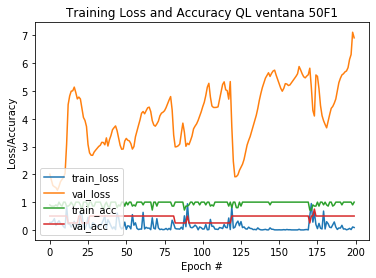

In [26]:
#plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy QL ventana 50F1")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(f"./Resultados/modelo_upd_{currentTime}.png")

# Probar red

In [18]:
from keras.preprocessing.image import img_to_array

In [31]:
def clasifica(path_image):
    prueba = cv2.imread(path_image, cv2.IMREAD_COLOR)
    prueba_resized = cv2.resize(prueba, (w, h))
    prueba_resized = prueba_resized.astype("float") / 255.0
    prueba_resized = img_to_array(prueba_resized)
    prueba_resized2 = np.expand_dims(prueba_resized, axis=0)
    prueba_resized.shape
    resultado = model.predict(prueba_resized2)[0]
    return ["Luffy", "NoLuffy"][np.argmax(resultado)]

clasifica("/home/dramon/Pictures/ore_no_e/One Piece/78997.jpg")

'NoLuffy'